# Experimentation with Classification

## Load Data and Pre-processing

The dataset selected is the [CIC-MalMem-2022 from the University of New Brunswick](https://www.unb.ca/cic/datasets/malmem-2022.html).

The dataset is tailored for assessing memory-based obfuscated malware detection techniques. It simulates real-world scenarios by featuring common malware types like Spyware, Ransomware, and Trojan Horses, offering a well-balanced dataset for testing obfuscated malware detection systems. Notably, it employs debug mode during memory dump processes to emulate the conditions typical users might encounter during a malware attack, enhancing its realism.

In the current form of the dataset, two columns, `Class` and `Category` can be used to represent the classifiers for the row. The `Class` column is a binary classifier that indicates whether the row is malware or benign. The `Category` column is a multi-class classifier that indicates the type of malware the row is.

The pre-processing of the data is done by splitting `Category` into two additional columns `mal_category` and `mal_family`. This is done to be able to perform more in depth experiments on the accuracy of the classifiers. The hypothesis is that the more specifc the classifier is; the less accurate the classifier will be. The most specific classifier will be the `mal_family`, followed by `mal_category`, and finally `Class`.



In [1]:
import numpy as np
import pandas as pd

Reads the data from the csv file and splits the `Category` column into two columns `mal_category` and `mal_family`.

In [2]:
# Only reads in this code block for caching purposes

cic_malware_memory = pd.read_csv("datasets/Obfuscated-MalMem2022.csv")

In [3]:
# Split `Category` column into `mal_category` and `mal_family`

mal_categories = []
mal_families = []

for index, row in cic_malware_memory.iterrows():
    # Category is formatted as `category-family-filehash`
    category = row["Category"].split("-")

    # If the length of the list is greater than 2,
    # then the category is the first element and
    # the family is the second element
    if len(category) > 2:
        mal_categories.append(category[0])
        mal_families.append(category[1])

    # Otherwise, the category and family are just
    # labelled as Benign
    else:
        mal_categories.append("Benign")
        mal_families.append("Benign")

# Add the new columns to the dataframe
cic_malware_memory["mal_category"] = mal_categories
cic_malware_memory["mal_family"] = mal_families


In [4]:
# The training and testing data will be split using the holdout method
# because the dataset is balanced the split will be 50/50

# Split the dataset into training and testing sets

train = cic_malware_memory.sample(frac=0.5, random_state=42)
test = cic_malware_memory.drop(train.index)

# Creates a list of all the features in the dataset
features = cic_malware_memory.columns.drop(["mal_category", "mal_family", "Class", "Category"]).to_list()

# Create the different classes for the three trial types

# Trial 1: Benign vs Malware
train_classes_trial1 = train["Class"].to_numpy().ravel()
test_classes_trial1 = test["Class"].to_numpy().ravel()

# Trial 2: Malware Category
train_classes_trial2 = train["mal_category"].to_numpy().ravel()
test_classes_trial2 = test["mal_category"].to_numpy().ravel()

# Trial 3: Malware Family
train_classes_trial3 = train["mal_family"].to_numpy().ravel()
test_classes_trial3 = test["mal_family"].to_numpy().ravel()

# Separate the observations data
train_observations = train[features].to_numpy()
test_observations = test[features].to_numpy()

## K Nearest Neighbor Classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def knn_experiment(n, train_observations, train_classes, test_observations) -> np.ndarray:
    """Performs a KNN experiment with the given parameters

    Parameters:
        n (int): The number of neighbors to use
        train_observations (ndarray): The training observations
        train_classes (ndarray): The training classes
        test_observations (ndarray): The testing observations

    Returns:
        ndarray: The predictions of the model
    """
    knn = KNeighborsClassifier(n_neighbors=n, weights="distance")
    knn.fit(train_observations, train_classes)

    predictions = knn.predict(test_observations)
    
    return predictions

## Decision Tree Classifier

In [6]:
from sklearn.tree import DecisionTreeClassifier

def dt_experiment(train_observations, train_classes, test_observations) -> np.ndarray:
    """Performs a Decision Tree experiment with the given parameters

    Parameters:
        train_observations (ndarray): The training observations
        train_classes (ndarray): The training classes
        test_observations (ndarray): The testing observations

    Returns:
        ndarray: The predictions of the model
    """
    dt = DecisionTreeClassifier()
    dt.fit(train_observations, train_classes)
    
    predictions = dt.predict(test_observations)
    return predictions

## Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

def rf_experiment(train_observations, train_classes, test_observations) -> np.ndarray:
    """Performs a Random Forest experiment with the given parameters

    Parameters:
        train_observations (ndarray): The training observations
        train_classes (ndarray): The training classes
        test_observations (ndarray): The testing observations

    Returns:
        ndarray: The predictions
    """
    rf = RandomForestClassifier()
    rf.fit(train_observations, train_classes)
    
    predictions = rf.predict(test_observations)
    return predictions


## Stacked Ensemble Classifier

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

def ensemble_experiment(train_observations, train_classes, test_observations) -> np.ndarray:
    """Performs an ensemble experiment with the given parameters

    Parameters:
        train_observations (ndarray): The training observations
        train_classes (ndarray): The training classes
        test_observations (ndarray): The testing observations

    Returns:
        ndarray: The predictions
    """
    estimators = [
        ("nb", GaussianNB()),
        ("dt", DecisionTreeClassifier()),
        ("rf", RandomForestClassifier())
    ]

    ensemble = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
    ensemble.fit(train_observations, train_classes)

    predictions = ensemble.predict(test_observations)
    return predictions

## Results

### Calculate Metrics for a DataFrame

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def calculate_metrics(y_true, y_pred):
    """Calculate the precision, recall, f1 score, and accuracy of the model.

    Args:
        y_true (numpy.ndarray): The true labels of the data
        y_pred (numpy.ndarray): The predicted labels of the data

    Returns:
        float: The precision of the model
        float: The recall of the model
        float: The f1 score of the model
        float: The accuracy of the model
    """
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy


def display_confusion_matrix(y_true, predictions_map, labels):
    f, axes = plt.subplots(1, len(predictions_map.keys()), figsize=(20, 5), sharey='row')
    
    for i, (key, predictions) in enumerate(predictions_map.items()):
        cfm = confusion_matrix(y_true, predictions, labels=labels, normalize="true")
        disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=labels)
        disp.plot(
            cmap="Blues",
            colorbar=False,
            ax=axes[i],
            xticks_rotation=45
        )
        disp.ax_.set_title(key)
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')
    
    f.text(0.4, 0, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.4, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()



### Trial 1: Benign vs Malware

,Precision,Recall,F1 Score,Accuracy
KNN,0.999284,0.999283,0.999283,0.999283
Decision Tree,0.999795,0.999795,0.999795,0.999795
Random Forest,0.999932,0.999932,0.999932,0.999932
Ensemble,0.999932,0.999932,0.999932,0.999932


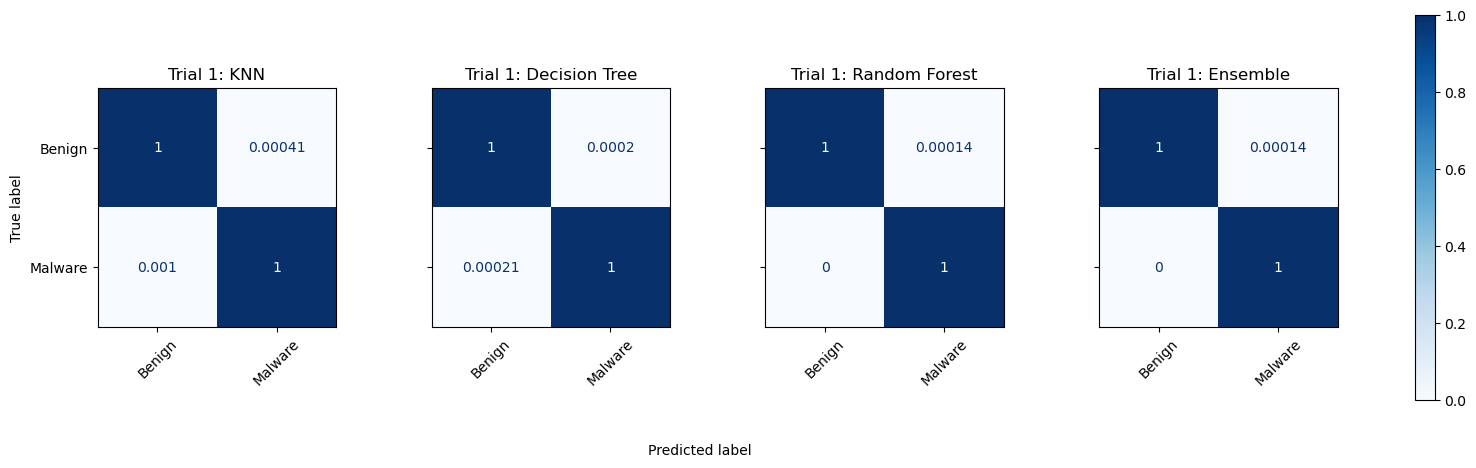

In [30]:
# KNN Experiment
trial1_knn_predictions = knn_experiment(5, train_observations, train_classes_trial1, test_observations)

# Decision Tree Experiment
trial1_dt_predictions = dt_experiment(train_observations, train_classes_trial1, test_observations)

# Random Forest Experiment
trial1_rf_predictions = rf_experiment(train_observations, train_classes_trial1, test_observations)

# Ensemble Experiment
trial1_ensemble_predictions = ensemble_experiment(train_observations, train_classes_trial1, test_observations)

# Calculate the metrics
trial1_knn_metrics = calculate_metrics(test_classes_trial1, trial1_knn_predictions)
trial1_dt_metrics = calculate_metrics(test_classes_trial1, trial1_dt_predictions)
trial1_rf_metrics = calculate_metrics(test_classes_trial1, trial1_rf_predictions)
trial1_ensemble_metrics = calculate_metrics(test_classes_trial1, trial1_ensemble_predictions)


# Create a DataFrame with the results
results = pd.DataFrame(columns=["Precision", "Recall", "F1 Score", "Accuracy"])
results.loc["KNN"] = trial1_knn_metrics
results.loc["Decision Tree"] = trial1_dt_metrics
results.loc["Random Forest"] = trial1_rf_metrics
results.loc["Ensemble"] = trial1_ensemble_metrics
display(results)

# Create confusion matrices for each model
labels = list(dict.fromkeys(test_classes_trial1))
predictions_map = {
    "Trial 1: KNN": trial1_knn_predictions,
    "Trial 1: Decision Tree": trial1_dt_predictions,
    "Trial 1: Random Forest": trial1_rf_predictions,
    "Trial 1: Ensemble": trial1_ensemble_predictions
}
display_confusion_matrix(test_classes_trial1, predictions_map=predictions_map, labels=labels)


### Trial 2: Malware Category

,Precision,Recall,F1 Score,Accuracy
KNN,0.712517,0.712559,0.712497,0.808929
Decision Tree,0.748278,0.748155,0.748203,0.832617
Random Forest,0.794591,0.794481,0.794518,0.863506
Ensemble,0.795229,0.795227,0.795205,0.863984
SVM,0.650603,0.642781,0.638110,0.760939


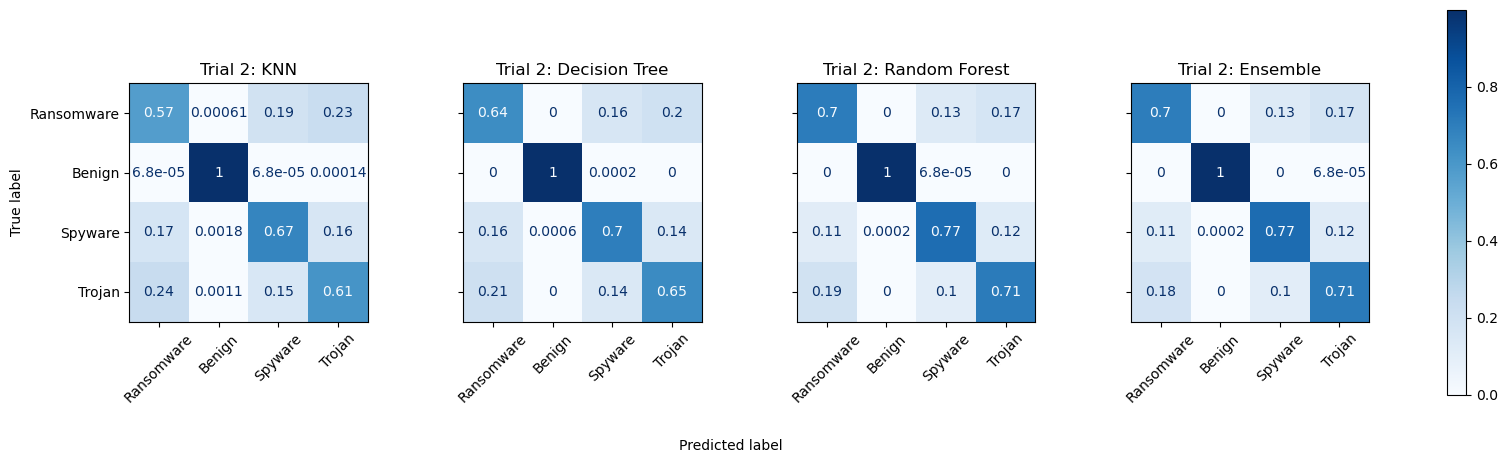

In [40]:
# KNN Experiment
trial2_knn_predictions = knn_experiment(5, train_observations, train_classes_trial2, test_observations)

# Decision Tree Experiment
trial2_dt_predictions = dt_experiment(train_observations, train_classes_trial2, test_observations)

# Random Forest Experiment
trial2_rf_predictions = rf_experiment(train_observations, train_classes_trial2, test_observations)

# Ensemble Experiment
trial2_ensemble_predictions = ensemble_experiment(train_observations, train_classes_trial2, test_observations)

# Calculate Metrics
trial2_knn_metrics = calculate_metrics(test_classes_trial2, trial2_knn_predictions)
trial2_dt_metrics = calculate_metrics(test_classes_trial2, trial2_dt_predictions)
trial2_rf_metrics = calculate_metrics(test_classes_trial2, trial2_rf_predictions)
trial2_ensemble_metrics = calculate_metrics(test_classes_trial2, trial2_ensemble_predictions)

# Create a DataFrame with the results
results = pd.DataFrame(columns=["Precision", "Recall", "F1 Score", "Accuracy"])
results.loc["KNN"] = trial2_knn_metrics
results.loc["Decision Tree"] = trial2_dt_metrics
results.loc["Random Forest"] = trial2_rf_metrics
results.loc["Ensemble"] = trial2_ensemble_metrics
display(results)

# Create confusion matrices for each model
labels = list(dict.fromkeys(train_classes_trial2))
predictions_map = {
    "Trial 2: KNN": trial2_knn_predictions,
    "Trial 2: Decision Tree": trial2_dt_predictions,
    "Trial 2: Random Forest": trial2_rf_predictions,
    "Trial 2: Ensemble": trial2_ensemble_predictions
}
display_confusion_matrix(test_classes_trial2, predictions_map=predictions_map, labels=labels)

### Trial 3: Malware Family

In [35]:
# KNN Experiment
trial3_knn_predictions = knn_experiment(5, train_observations, train_classes_trial3, test_observations)

# Decision Tree Experiment
trial3_dt_predictions = dt_experiment(train_observations, train_classes_trial3, test_observations)

# Random Forest Experiment
trial3_rf_predictions = rf_experiment(train_observations, train_classes_trial3, test_observations)

# Ensemble Experiment
trial3_ensemble_predictions = ensemble_experiment(train_observations, train_classes_trial3, test_observations)

# Calculate Metrics
trial3_knn_metrics = calculate_metrics(test_classes_trial3, trial3_knn_predictions)
trial3_dt_metrics = calculate_metrics(test_classes_trial3, trial3_dt_predictions)
trial3_rf_metrics = calculate_metrics(test_classes_trial3, trial3_rf_predictions)
trial3_ensemble_metrics = calculate_metrics(test_classes_trial3, trial3_ensemble_predictions)

# Create a DataFrame with the results
results = pd.DataFrame(columns=["Precision", "Recall", "F1 Score", "Accuracy"])
results.loc["KNN"] = trial3_knn_metrics
results.loc["Decision Tree"] = trial3_dt_metrics
results.loc["Random Forest"] = trial3_rf_metrics
results.loc["Ensemble"] = trial3_ensemble_metrics
display(results)

# Since the accuracy is so low, we won't create a confusion matrix for this experiment.

,Precision,Recall,F1 Score,Accuracy
KNN,0.401243,0.405338,0.401559,0.682299
Decision Tree,0.468307,0.466737,0.467259,0.714451
Random Forest,0.517537,0.515921,0.514976,0.740904
Ensemble,0.520349,0.516357,0.515881,0.741109
